# TP de Graphe :
# 1.1 Construction du graphe

In [249]:
import matplotlib.pyplot as plt
import math

class Graphe:
    def __init__(self):
        self.sommets = {}
        self.types = {}  
        self.aretes = []
        self.debut = None
        self.fin = None

    def ajouter_sommet(self, sommet, pos, type_sommet):
        self.sommets[sommet] = pos
        self.types[sommet] = type_sommet
        if type_sommet == 2:
            self.definir_debut(sommet)
        elif type_sommet == 3:
            self.definir_fin(sommet)

    def definir_debut(self, sommet):
        if self.debut is not None:
            raise ValueError("Un point de départ est déjà défini.")
        self.debut = sommet
        print(f"Sommet de départ défini: {sommet}")

    def definir_fin(self, sommet):
        if self.fin is not None:
            raise ValueError("Un point d'arrivée est déjà défini.")
        self.fin = sommet
        print(f"Sommet d'arrivée défini: {sommet}")

    def ajouter_arete(self, sommet1, sommet2):
        if self.est_adjacent(sommet1, sommet2):
            if self.types.get(sommet1) != 0 and self.types.get(sommet2) != 0:
                poids = self.calculer_poids(sommet1, sommet2)
                self.aretes.append((sommet1, sommet2, poids))
                print(f"Arête ajoutée: {sommet1} -> {sommet2}, Coût = {poids}")
            else:
                print("Impossible de tracer une arête entre des sommets non praticables.")
        else:
            print("Les sommets ne sont pas adjacents et ne peuvent pas être connectés.")


    def est_adjacent(self, sommet1, sommet2):
        i1, j1 = sommet1
        i2, j2 = sommet2
        return abs(i1 - i2) <= 1 and abs(j1 - j2) <= 1
    
    def calculer_poids(self, sommet1, sommet2):
        i1, j1 = sommet1
        i2, j2 = sommet2
        di = abs(i1 - i2)
        dj = abs(j1 - j2)
        
        if di == 1 and dj == 1:
            return math.sqrt(2)  
        else:
            return 1 

    def tracer_graphe(self):
        plt.figure(figsize=(10, 8))
        for sommet1, sommet2, poids in self.aretes:
            if self.types[sommet1] != 0 and self.types[sommet2] != 0:
                plt.plot([self.sommets[sommet1][1], self.sommets[sommet2][1]], 
                         [self.sommets[sommet1][0], self.sommets[sommet2][0]], 'bo-', linewidth=1, markersize=5)
        
        for sommet, pos in self.sommets.items():
            if sommet == self.debut:
                plt.plot(pos[1], pos[0], 'go', label='Départ', markersize=10)
            elif sommet == self.fin:
                plt.plot(pos[1], pos[0], 'ro', label='Arrivée', markersize=10)
            elif self.types[sommet] == 0:
                plt.plot(pos[1], pos[0], 'ko', markersize=5, color='grey', alpha=0.5)  # Grisé pour les obstacles
            else:
                plt.plot(pos[1], pos[0], 'ko', markersize=5)  # Normal pour les sommets praticables
        
        plt.gca().invert_yaxis()  # Inversion de l'axe Y pour une visualisation conforme à la grille
        plt.xlabel('Coordonnée X')
        plt.ylabel('Coordonnée Y')
        plt.title('Visualisation du Graphe')
        plt.legend()
        plt.grid(True)
        plt.show()
        

In [250]:
def creer_graphe_fichier(nom_fichier):
    graphe = Graphe()
    with open(nom_fichier, 'r') as fichier:
        n, m = map(int, fichier.readline().split())
        grille = [list(map(int, fichier.readline().split())) for _ in range(n)]
        
        for i in range(n):
            for j in range(m):
                valeur = grille[i][j]
                graphe.ajouter_sommet((i, j), (i, j), valeur)
                
                if valeur in [1, 2, 3]:
                    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
                    for di, dj in directions:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < n and 0 <= nj < m:
                            graphe.ajouter_arete((i, j), (ni, nj))
    return graphe


Arête ajoutée: (0, 0) -> (1, 0), Coût = 1
Arête ajoutée: (0, 0) -> (0, 1), Coût = 1
Arête ajoutée: (0, 0) -> (1, 1), Coût = 1.4142135623730951
Sommet de départ défini: (0, 1)
Arête ajoutée: (0, 1) -> (1, 1), Coût = 1
Arête ajoutée: (0, 1) -> (0, 0), Coût = 1
Arête ajoutée: (0, 1) -> (0, 2), Coût = 1
Arête ajoutée: (0, 1) -> (1, 0), Coût = 1.4142135623730951
Arête ajoutée: (0, 1) -> (1, 2), Coût = 1.4142135623730951
Arête ajoutée: (0, 2) -> (1, 2), Coût = 1
Arête ajoutée: (0, 2) -> (0, 1), Coût = 1
Arête ajoutée: (0, 2) -> (0, 3), Coût = 1
Arête ajoutée: (0, 2) -> (1, 1), Coût = 1.4142135623730951
Arête ajoutée: (0, 2) -> (1, 3), Coût = 1.4142135623730951
Arête ajoutée: (0, 3) -> (1, 3), Coût = 1
Arête ajoutée: (0, 3) -> (0, 2), Coût = 1
Arête ajoutée: (0, 3) -> (0, 4), Coût = 1
Arête ajoutée: (0, 3) -> (1, 2), Coût = 1.4142135623730951
Arête ajoutée: (0, 3) -> (1, 4), Coût = 1.4142135623730951
Arête ajoutée: (0, 4) -> (1, 4), Coût = 1
Arête ajoutée: (0, 4) -> (0, 3), Coût = 1
Arête ajo

C:\Users\pyrof\AppData\Local\Temp\ipykernel_16572\2041695897.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pos[1], pos[0], 'ko', markersize=5, color='grey', alpha=0.5)  # Grisé pour les obstacles


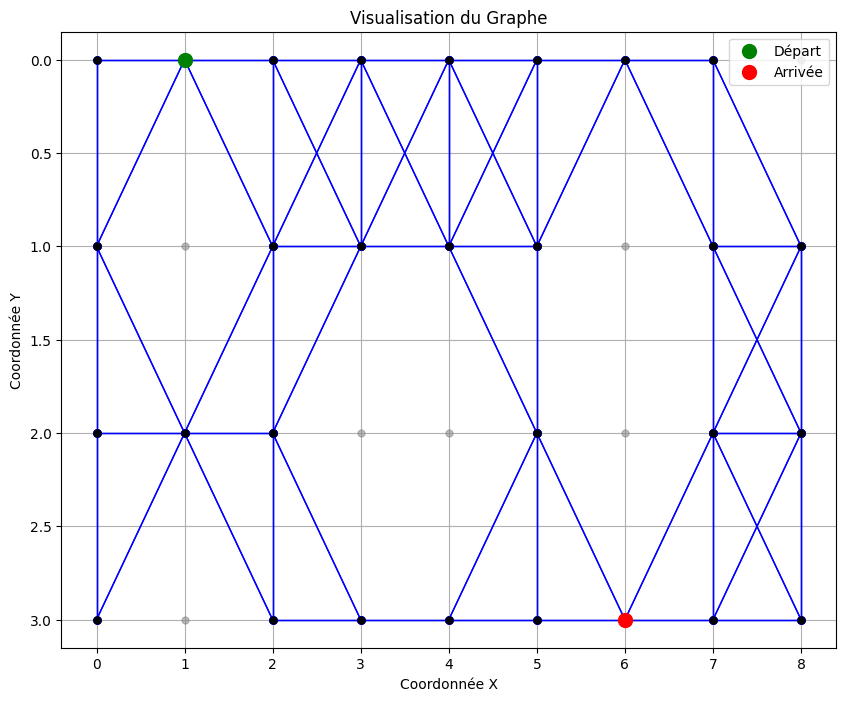

In [251]:
filename = "exo1.txt"
graphe = creer_graphe_fichier(filename)
print(graphe)
graphe.tracer_graphe()

Arête ajoutée: (0, 9) -> (1, 8), Coût = 1.4142135623730951
Impossible de tracer une arête entre des sommets non praticables.
Impossible de tracer une arête entre des sommets non praticables.
Les sommets ne sont pas adjacents et ne peuvent pas être connectés.


C:\Users\pyrof\AppData\Local\Temp\ipykernel_16572\2041695897.py:73: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(pos[1], pos[0], 'ko', markersize=5, color='grey', alpha=0.5)  # Grisé pour les obstacles


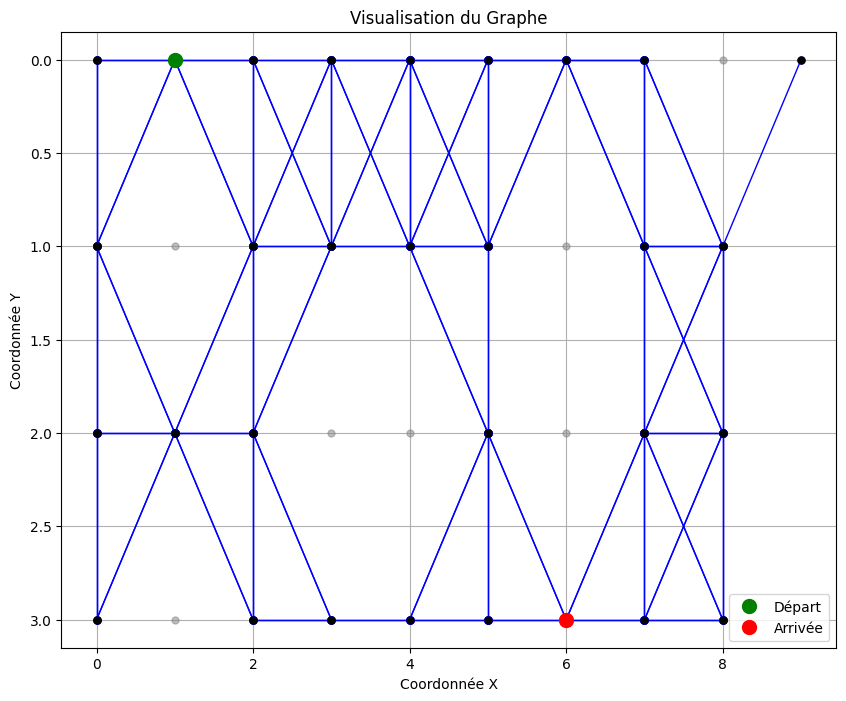

In [252]:
graphe.ajouter_sommet((0,9),(0,9),1)
graphe.ajouter_arete((0, 9), (1, 8)) 
graphe.ajouter_arete((0, 9), (0, 8)) 
graphe.ajouter_arete((0, 1), (1, 1)) 
graphe.ajouter_arete((1,5),(1,0))

graphe.tracer_graphe()


# 1.2 Modélisation mathématique

## Modélisation du Problème en Programmation Linéaire

Le problème du plus court chemin dans un graphe peut être formulé comme un problème de programmation linéaire. Ce problème consiste à trouver le chemin le moins coûteux entre une source et une destination dans un graphe.

### Variables
Pour chaque arête $(u, v)$ dans le graphe, nous définissons une variable binaire $x_{uv}$ qui indique si l'arête $(u, v)$ est utilisée dans le chemin le plus court.

### Fonction Objectif
La fonction objectif est de minimiser le coût total du chemin. Cela est exprimé comme suit :

$$ \min \sum_{(u, v) \in E} c_{uv} x_{uv} $$

où $c_{uv}$ représente le coût de l'arête $(u, v)$.

### Contraintes

#### Conservation du Flux
Pour chaque sommet $v$ autre que la source $s$ et la destination $t$, la conservation du flux doit être respectée :

$$ \sum_{(u, v) \in E} x_{uv} - \sum_{(v, w) \in E} x_{vw} = 0 $$

#### Contraintes de la Source et de la Destination
La source $s$ doit avoir exactement une arête sortante active et la destination $t$ doit avoir exactement une arête entrante active :

- Pour la source $s$ :
$$ \sum_{(s, v) \in E} x_{sv} = 1 $$

- Pour la destination $t$ :
$$ \sum_{(u, t) \in E} x_{ut} = 1 $$

## Résumé
Cette modélisation permet de transformer le problème du plus court chemin en un problème de programmation linéaire, où la solution optimale indique le chemin le plus court en termes de coût entre deux points donnés dans un réseau.


## Implémentation avec CPLEX

In [253]:
import cplex
from cplex.exceptions import CplexError

def preparer_probleme(graphe, debut, fin):
    prob = cplex.Cplex()
    prob.set_problem_type(cplex.Cplex.problem_type.LP)
    
    prob.objective.set_sense(prob.objective.sense.minimize)

    variables_aretes = []
    couts = []
    for (sommet1, sommet2, poids) in graphe.aretes: 
        nom_variable = "x_" + str(sommet1) + "_" + str(sommet2)
        variables_aretes.append(nom_variable)
        couts.append(poids)
        prob.variables.add(obj=[poids], lb=[0], ub=[1], types=["B"], names=[nom_variable])
        print("Variable ajoutée:", nom_variable, ", Coût =", poids) 

    for sommet in graphe.sommets: 
        aretes_sortantes = []
        aretes_entrantes = []
        for sommet1, sommet2, poids in graphe.aretes:
            if sommet1 == sommet:
                aretes_sortantes.append("x_" + str(sommet) + "_" + str(sommet2))
            if sommet2 == sommet:
                aretes_entrantes.append("x_" + str(sommet1) + "_" + str(sommet))
        
        if sommet == debut:
            prob.linear_constraints.add(
                lin_expr=[cplex.SparsePair(ind=aretes_sortantes, val=[1]*len(aretes_sortantes))],
                senses=["E"], rhs=[1]
            )
            prob.linear_constraints.add(
                lin_expr=[cplex.SparsePair(ind=aretes_entrantes, val=[1]*len(aretes_entrantes))],
                senses=["E"], rhs=[0]
            )
        elif sommet == fin:
            prob.linear_constraints.add(
                lin_expr=[cplex.SparsePair(ind=aretes_entrantes, val=[1]*len(aretes_entrantes))],
                senses=["E"], rhs=[1]
            )
            prob.linear_constraints.add(
                lin_expr=[cplex.SparsePair(ind=aretes_sortantes, val=[1]*len(aretes_sortantes))],
                senses=["E"], rhs=[0]
            )
        else:
            prob.linear_constraints.add(
                lin_expr=[cplex.SparsePair(ind=aretes_sortantes + aretes_entrantes, val=[1]*len(aretes_sortantes) + [-1]*len(aretes_entrantes))],
                senses=["E"], rhs=[0]
            )
    
    return prob

def resoudre_probleme(prob):
    try:
        prob.solve()
    except CplexError as exc:
        print(exc)
        return None
    
    print("État de la solution = ", prob.solution.get_status(), ":", prob.solution.status[prob.solution.get_status()])
    print("Valeur de la solution  = ", prob.solution.get_objective_value())
    
    x = prob.solution.get_values()
    noms_aretes = prob.variables.get_names()
    aretes_selectionnees = [noms_aretes[i] for i in range(len(x)) if x[i] > 0.5]
    print("Aretes sélectionnées:", aretes_selectionnees)


In [254]:
prob = preparer_probleme(graphe, graphe.debut, graphe.fin)
resoudre_probleme(prob)

Variable ajoutée: x_(0, 0)_(1, 0) , Coût = 1
Variable ajoutée: x_(0, 0)_(0, 1) , Coût = 1
Variable ajoutée: x_(0, 0)_(1, 1) , Coût = 1.4142135623730951
Variable ajoutée: x_(0, 1)_(1, 1) , Coût = 1
Variable ajoutée: x_(0, 1)_(0, 0) , Coût = 1
Variable ajoutée: x_(0, 1)_(0, 2) , Coût = 1
Variable ajoutée: x_(0, 1)_(1, 0) , Coût = 1.4142135623730951
Variable ajoutée: x_(0, 1)_(1, 2) , Coût = 1.4142135623730951
Variable ajoutée: x_(0, 2)_(1, 2) , Coût = 1
Variable ajoutée: x_(0, 2)_(0, 1) , Coût = 1
Variable ajoutée: x_(0, 2)_(0, 3) , Coût = 1
Variable ajoutée: x_(0, 2)_(1, 1) , Coût = 1.4142135623730951
Variable ajoutée: x_(0, 2)_(1, 3) , Coût = 1.4142135623730951
Variable ajoutée: x_(0, 3)_(1, 3) , Coût = 1
Variable ajoutée: x_(0, 3)_(0, 2) , Coût = 1
Variable ajoutée: x_(0, 3)_(0, 4) , Coût = 1
Variable ajoutée: x_(0, 3)_(1, 2) , Coût = 1.4142135623730951
Variable ajoutée: x_(0, 3)_(1, 4) , Coût = 1.4142135623730951
Variable ajoutée: x_(0, 4)_(1, 4) , Coût = 1
Variable ajoutée: x_(0, 4)